**Assignmnet 1**

***1. Loading and preprocessing Data***

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from torchvision.io.image import read_image
from torchvision.transforms.functional import normalize, resize, to_pil_image

# Define dataset paths
data_dir = "chest_xray"
train_dir = f"{data_dir}/train"
val_dir = f"{data_dir}/val"
test_dir = f"{data_dir}/test"

# Define transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform_train)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)


***2. Training Model***

Training ResNet-18 from scratch...
Epoch 1/10, Loss: 0.2183, Val Loss: 0.9809, Val Acc: 62.50%
Model saved at epoch 1 with Val Loss: 0.9809 and Val Acc: 62.50%
Epoch 2/10, Loss: 0.1446, Val Loss: 1.1596, Val Acc: 56.25%
Epoch 3/10, Loss: 0.1285, Val Loss: 1.2877, Val Acc: 62.50%
Epoch 4/10, Loss: 0.1120, Val Loss: 0.3577, Val Acc: 75.00%
Model saved at epoch 4 with Val Loss: 0.3577 and Val Acc: 75.00%
Epoch 5/10, Loss: 0.1055, Val Loss: 1.2863, Val Acc: 68.75%
Epoch 6/10, Loss: 0.0947, Val Loss: 1.3353, Val Acc: 62.50%
Epoch 7/10, Loss: 0.1140, Val Loss: 2.2612, Val Acc: 50.00%
Epoch 8/10, Loss: 0.0925, Val Loss: 1.4902, Val Acc: 56.25%
Epoch 9/10, Loss: 0.1003, Val Loss: 1.3203, Val Acc: 56.25%
Epoch 10/10, Loss: 0.0908, Val Loss: 0.8697, Val Acc: 62.50%


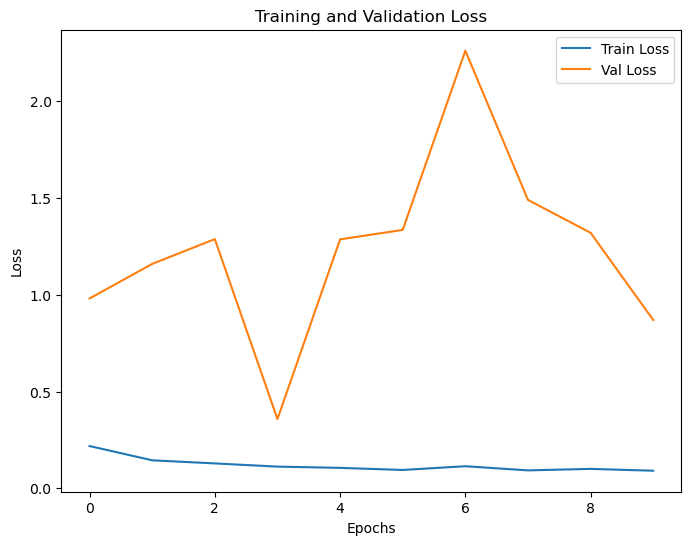

Fine-tuning Pretrained ResNet-18...
Epoch 1/10, Loss: 0.3337, Val Loss: 0.3353, Val Acc: 68.75%
Model saved at epoch 1 with Val Loss: 0.3353 and Val Acc: 68.75%
Epoch 2/10, Loss: 0.1883, Val Loss: 0.2439, Val Acc: 93.75%
Model saved at epoch 2 with Val Loss: 0.2439 and Val Acc: 93.75%
Epoch 3/10, Loss: 0.1594, Val Loss: 0.3009, Val Acc: 75.00%
Epoch 4/10, Loss: 0.1592, Val Loss: 0.2978, Val Acc: 75.00%
Epoch 5/10, Loss: 0.1334, Val Loss: 0.3133, Val Acc: 81.25%
Epoch 6/10, Loss: 0.1374, Val Loss: 0.3639, Val Acc: 75.00%
Epoch 7/10, Loss: 0.1374, Val Loss: 0.4589, Val Acc: 75.00%
Epoch 8/10, Loss: 0.1463, Val Loss: 0.3062, Val Acc: 81.25%
Epoch 9/10, Loss: 0.1316, Val Loss: 0.3482, Val Acc: 81.25%
Epoch 10/10, Loss: 0.1264, Val Loss: 0.3296, Val Acc: 81.25%


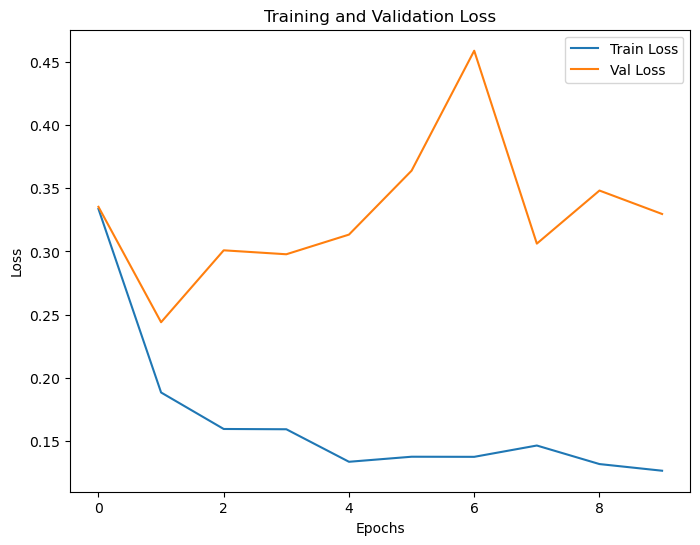

In [11]:
# Create data loaders
batch_size = 32
epochs = 10
learning_rate = 0.001
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to train the model and save the best checkpoint
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10, save_path="best_model.pth"):
    model.to(device)
    train_losses, val_losses = [], []
    best_val_loss = float('inf')
    best_val_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_losses.append(running_loss / len(train_loader))
        val_loss, val_acc = evaluate_model(model, val_loader, criterion)
        # scheduler.step(val_loss)
        val_losses.append(val_loss)

        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        # Save the model if validation loss decreases or validation accuracy improves
        if val_loss < best_val_loss or val_acc > best_val_acc:
            best_val_loss = min(best_val_loss, val_loss)
            best_val_acc = max(best_val_acc, val_acc)
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with Val Loss: {best_val_loss:.4f} and Val Acc: {best_val_acc:.2f}%")

    plot_loss_curve(train_losses, val_losses)
    return model

# Function to evaluate model
def evaluate_model(model, loader, criterion=None):
    model.eval()
    correct, total = 0, 0
    loss = 0.0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            if criterion:
                loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (loss / len(loader) if criterion else None), 100 * correct / total

# Function to plot loss curve
def plot_loss_curve(train_losses, val_losses):
    plt.figure(figsize=(8, 6))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')
    plt.show()

# Task 1.1 - Train ResNet-18 from scratch
model_scratch = models.resnet18(weights=None)
model_scratch.fc = nn.Linear(model_scratch.fc.in_features, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_scratch.parameters(), lr=learning_rate,weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
print("Training ResNet-18 from scratch...")
model_scratch = train_model(model_scratch, train_loader, val_loader, criterion, optimizer, epochs, save_path="resnet18_scratch.pth")

# Task 1.2 - Fine-tune Pretrained ResNet-18
model_pretrained = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
for param in model_pretrained.parameters():
    param.requires_grad = False
model_pretrained.fc = nn.Linear(model_pretrained.fc.in_features, 2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pretrained.fc.parameters(), lr=learning_rate, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

print("Fine-tuning Pretrained ResNet-18...")
model_pretrained = train_model(model_pretrained, train_loader, val_loader, criterion, optimizer, epochs, save_path="resnet18_pretrained.pth")

**3. Model Evaluation**


This is essentially just loading the trained models to evaluate.

In [12]:
# Load the best models before testing
model_scratch.load_state_dict(torch.load("resnet18_scratch.pth"))
model_pretrained.load_state_dict(torch.load("resnet18_pretrained.pth"))

# Evaluate models on the test set
test_loss_scratch, test_acc_scratch = evaluate_model(model_scratch, test_loader, criterion)
test_loss_pretrained, test_acc_pretrained = evaluate_model(model_pretrained, test_loader, criterion)
print(f"Test Accuracy (ResNet-18 from Scratch): {test_acc_scratch:.2f}%")
print(f"Test Accuracy (Fine-tuned ResNet-18): {test_acc_pretrained:.2f}%")

Test Accuracy (ResNet-18 from Scratch): 86.38%
Test Accuracy (Fine-tuned ResNet-18): 90.87%


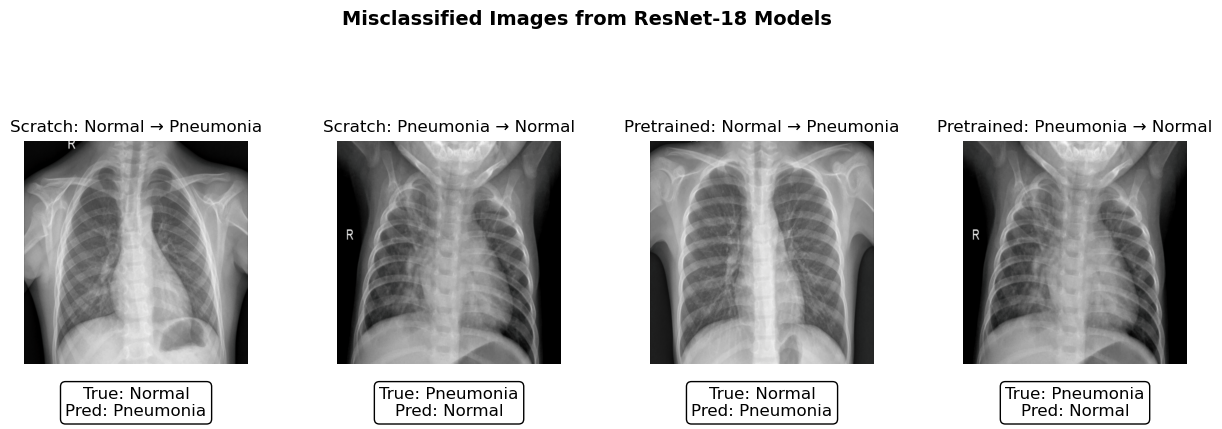

In [21]:
import torch
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image

# Function to revert normalization
def denormalize(tensor, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return tensor * std + mean  # Revert normalization

# Mean and std values used in transformation
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# Ensure models are in evaluation mode
model_scratch.eval()
model_pretrained.eval()

# Storage for misclassified images
misclassified_images = {
    "scratch_normal_to_pneumonia": None,
    "scratch_pneumonia_to_normal": None,
    "pretrained_normal_to_pneumonia": None,
    "pretrained_pneumonia_to_normal": None,
}

# Class labels
class_labels = {0: "Normal", 1: "Pneumonia"}

# Iterate over test dataset
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Predictions from both models
        outputs_scratch = model_scratch(images)
        outputs_pretrained = model_pretrained(images)

        _, predicted_scratch = torch.max(outputs_scratch, 1)
        _, predicted_pretrained = torch.max(outputs_pretrained, 1)

        for i in range(len(labels)):
            true_label = labels[i].item()
            pred_scratch = predicted_scratch[i].item()
            pred_pretrained = predicted_pretrained[i].item()

            # Misclassified cases for ResNet-18 from scratch
            if pred_scratch != true_label:
                key = f"scratch_{class_labels[true_label].lower()}_to_{class_labels[pred_scratch].lower()}"
                if misclassified_images[key] is None:
                    misclassified_images[key] = (images[i].cpu(), pred_scratch, true_label)

            # Misclassified cases for fine-tuned ResNet-18
            if pred_pretrained != true_label:
                key = f"pretrained_{class_labels[true_label].lower()}_to_{class_labels[pred_pretrained].lower()}"
                if misclassified_images[key] is None:
                    misclassified_images[key] = (images[i].cpu(), pred_pretrained, true_label)

            # Stop when all cases are found
            if all(misclassified_images.values()):
                break
        if all(misclassified_images.values()):
            break

# Display the misclassified images in a single row
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

# Define labels for models
titles = [
    "Scratch: Normal → Pneumonia",
    "Scratch: Pneumonia → Normal",
    "Pretrained: Normal → Pneumonia",
    "Pretrained: Pneumonia → Normal",
]

for i, (key, title) in enumerate(zip(misclassified_images.keys(), titles)):
    if misclassified_images[key]:
        img, pred, true = misclassified_images[key]
        img = denormalize(img, mean, std).clamp(0, 1)  # Revert normalization
        axes[i].imshow(to_pil_image(img))
        axes[i].axis('off')

        # Add labels on the images
        label_text = f"True: {class_labels[true]}\nPred: {class_labels[pred]}"
        axes[i].text(
            0.5, -0.1, label_text,
            fontsize=12, ha='center', va='top',
            transform=axes[i].transAxes,
            bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3')
        )

        # Set titles
        axes[i].set_title(title, fontsize=12)

plt.subplots_adjust(wspace=0.4)  # Adjust spacing for better visibility
plt.suptitle("Misclassified Images from ResNet-18 Models", fontsize=14, fontweight='bold')
plt.show()


In [24]:
import torch
import torch.nn as nn
from collections import defaultdict

def evaluate_model(model, test_loader, device, model_name):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    # Class labels
    class_labels = {0: "Normal", 1: "Pneumonia"}  

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-class accuracy calculation
            for label, pred in zip(labels, predicted):
                class_total[label.item()] += 1
                if label.item() == pred.item():
                    class_correct[label.item()] += 1

    # Compute overall accuracy
    overall_acc = 100 * correct / total

    # Compute per-class accuracy
    per_class_acc = {class_labels[c]: 100 * class_correct[c] / class_total[c] if class_total[c] > 0 else 0 
                     for c in class_labels.keys()}
    
    return model_name, overall_acc, per_class_acc

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Evaluate both models
results = []
results.append(evaluate_model(model_scratch, test_loader, device, "ResNet-Scratch"))
results.append(evaluate_model(model_pretrained, test_loader, device, "ResNet-Pretrained"))

# Print the table header
print(f"{'Model':<20}{'Overall Accuracy':<20}{'Normal Accuracy':<20}{'Pneumonia Accuracy'}")
print("=" * 80)

# Print each row of results
for model_name, overall_acc, per_class_acc in results:
    print(f"{model_name:<20}{overall_acc:.2f}%{' ' * 10}{per_class_acc['Normal']:.2f}%{' ' * 10}{per_class_acc['Pneumonia']:.2f}%")


Model               Overall Accuracy    Normal Accuracy     Pneumonia Accuracy
ResNet-Scratch      86.38%          70.51%          95.90%
ResNet-Pretrained   90.87%          85.04%          94.36%
